# Algoritmi supervisionati

## In questa sezione vengono applicati gli algoritmi supervisionati

### Import delle librerie e moduli necessari

In [97]:
# librerie generali
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# librerie per la rappresentazione del dataset
from sklearn.feature_extraction.text import TfidfVectorizer

# libreria per suddividere il dataset in train e test set
from sklearn.model_selection import train_test_split

# libreria utilizzata per l'ottimizzazione dei parametri
from sklearn.model_selection import GridSearchCV

# librerie utilizzate per le misure
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

# libreria utilizzata per la cross validation
from sklearn.model_selection import cross_val_score

# libreria per il Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# libreria utilizzata per il Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# libreria utilizzata per il KNN
from sklearn.neighbors import KNeighborsClassifier

# libreria utilizzata per la rete neurale
from sklearn.neural_network import MLPClassifier

# libreria utilizzata per il support vector machine
from sklearn.svm import SVC

# seed utilizzato per la generazione del train e test set
random_seed = 3

# 1. Creazione dataset con rappresentazione tf-idf

In [98]:
%store -r clean_dataset

In [99]:
def createDataframeWithTfIdf(dataframe):
    reviewText = dataframe['reviewText'].to_numpy()
    vectorizer = TfidfVectorizer(sublinear_tf=True)
    tfidf_vector = vectorizer.fit_transform(reviewText)
    tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=reviewText, columns=vectorizer.get_feature_names())
    
    tfidf_df['numberPositiveReview'] = dataframe['numberPositiveReview'].to_numpy()
    tfidf_df['numberNegativeReview'] = dataframe['numberNegativeReview'].to_numpy()
    tfidf_df.reset_index(drop=True, inplace=True)
    sentiment = dataframe['sentiment']
    return tfidf_df, sentiment

In [100]:
dataset, labels = createDataframeWithTfIdf(clean_dataset)

In [101]:
print(dataset.shape)

(12000, 41695)


# 2. Definizione della funzione K-fold cross validation

## Questa funzione viene utilizzata per effettuare la K-fold cross validation sui varia classificatori. La cross validation viene effettuata per valori di k in [10, 15]

In [102]:
def kCrossValidation(model, dataset, labels):
    k = []
    acc = []
    dev = []

    #nota, non viene effettuato lo shuffle dei fold, quindi sono sempre gli stessi, sono già istanziati
    for i in range(10, 16):
        scores = cross_val_score(model, dataset, labels, cv=i)
        print("K cross validation, k= ", i)
        k.append(i)
        print("Average scores: ", scores.mean())
        acc.append(scores.mean())
        print("Standard Deviation of scores: ", scores.std())
        dev.append(scores.std())
        print("\n\n")

## 2.1 Definizione funzione per la visualizzazione dei grafici

In [103]:
def report_scores(Y_test, y_predicted):
    print("Accuracy score: ", accuracy_score(Y_test, y_predicted))
    print(classification_report(Y_test, y_predicted, target_names=["Negativo", "Positivo"]))
    
    cf_matrix = confusion_matrix(Y_test, y_predicted)

    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Negativo','Positivo'])
    ax.yaxis.set_ticklabels(['Negativo','Positivo'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# 3. Random Forest

## 3.1 Random Forest: Feature Selection

### Prima di applicare il random forest per la classificazione, viene effettuata la feature selection per estrarre le feature più importanti, avendo il dataset nella rappresentazione tf-idf

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=random_seed)
    
rf = RandomForestClassifier(criterion = 'entropy', random_state=random_seed)
rf.fit(X_train, Y_train)
y_pred=rf.predict(X_test)

# feature selection
sel = SelectFromModel(rf, prefit=True)
selected_feat = dataset.columns[(sel.get_support())]
print("Numero feature selezionate: " + str(len(selected_feat)))

featureSelection_df = dataset.loc[:, sel.get_support()]

Numero feature selezionate: 3312


## 3.2 Random Forest: Parameter Tuning

### Dopo aver effettuato la feature selection, viene attuato il paramater tuning sulle feature più importanti tramite una ricerca esaustiva dello spazio di ricerca

### Parametri su cui viene effettuata la ricerca

In [105]:
n_estimators_list = [40,60,80,100]
criterion_list = ['entropy']
max_depth_list = [35,55]
max_depth_list.append(None)
min_samples_split_list = [15, 30]
min_samples_leaf_list = [5, 15, 30]
max_features_list = ['log2']

In [106]:
params_grid = {
    'n_estimators': n_estimators_list,
    'criterion': criterion_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'max_features': max_features_list
}

In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)


def my_acc_score(model, truncated_df, labels):
    return metrics.accuracy_score(labels, model.predict(truncated_df))

### Ricerca dei parametri migliori

In [108]:
rf_searchParameter = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                            param_grid=params_grid,
                            cv=3,
                            return_train_score=True,
                            verbose=2,
                            scoring = my_acc_score
                            )

rf_searchParameter.fit(X_train, Y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   0.6s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   0.6s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   0.6s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.8s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.8s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.7s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n

[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=100; total time=   0.7s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.4s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.5s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.4s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.4s
[CV] END criterion=

[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=100; total time=   1.0s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=100; total time=   1.0s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=60; total time=   0.4s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=60; total time=   0.4s
[CV] END criterion

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   1.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   1.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   1.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.6s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.5s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=60; total time=   0.7s
[CV

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['entropy'], 'max_depth': [35, 55, None],
                         'max_features': ['log2'],
                         'min_samples_leaf': [5, 15, 30],
                         'min_samples_split': [15, 30],
                         'n_estimators': [40, 60, 80, 100]},
             return_train_score=True,
             scoring=<function my_acc_score at 0x0000024C32B04A60>, verbose=2)

### Parametri migliori trovati

In [109]:
best_param = rf_searchParameter.best_params_
print("Parametri migliori trovati:\n")
for pair in best_param.items():
    print(pair)
    
'''
('criterion', 'entropy')
('max_depth', None)
('max_features', 'log2')
('min_samples_leaf', 5)
('min_samples_split', 30)
('n_estimators', 100)
'''

Parametri migliori trovati:

('criterion', 'entropy')
('max_depth', None)
('max_features', 'log2')
('min_samples_leaf', 5)
('min_samples_split', 30)
('n_estimators', 100)


In [110]:
df_cv_results = pd.DataFrame(rf_searchParameter.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                           'param_n_estimators', 'param_min_samples_split','param_min_samples_leaf',
                           'param_max_features', 'param_max_depth','param_criterion']]
df_cv_results.sort_values('rank_test_score', inplace=True)
df_cv_results[:10]

,rank_test_score,mean_test_score,mean_train_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion
55,1,0.805104,0.897187,100,30,5,log2,None,entropy
30,2,0.803021,0.880625,80,30,5,log2,55,entropy
31,3,0.802812,0.886250,100,30,5,log2,55,entropy
51,4,0.801771,0.895677,100,15,5,log2,None,entropy
50,5,0.801458,0.893854,80,15,5,log2,None,entropy
26,6,0.800000,0.883177,80,15,5,log2,55,entropy
27,7,0.798229,0.884635,100,15,5,log2,55,entropy
29,8,0.798021,0.878333,60,30,5,log2,55,entropy
49,9,0.797500,0.890990,60,15,5,log2,None,entropy
54,10,0.797396,0.893542,80,30,5,log2,None,entropy


## 3.3 Random Forest: Classificazione

### Prendo i parametri migliori trovati per effettuare la classificazione

In [111]:
n_estimators_found = best_param.get('n_estimators')
max_depth_found = best_param.get('max_depth')
max_features_found = best_param.get('max_features')
min_samples_leaf_found = best_param.get('min_samples_leaf')
min_samples_split_found = best_param.get('min_samples_split')
criterion_found = best_param.get('criterion')

### Task di classificazione

In [112]:
rf = RandomForestClassifier(n_estimators = n_estimators_found, 
                            criterion = criterion_found,
                            class_weight= 'balanced',
                            max_depth= max_depth_found,
                            max_features= max_features_found,
                            min_samples_leaf= min_samples_leaf_found,
                            min_samples_split= min_samples_split_found)
rf.fit(X_train, Y_train)

train_prediction = rf.predict(X_train)
test_prediction = rf.predict(X_test)

Accuracy score:  0.8075
              precision    recall  f1-score   support

    Negativo       0.81      0.81      0.81      1213
    Positivo       0.81      0.81      0.81      1187

    accuracy                           0.81      2400
   macro avg       0.81      0.81      0.81      2400
weighted avg       0.81      0.81      0.81      2400



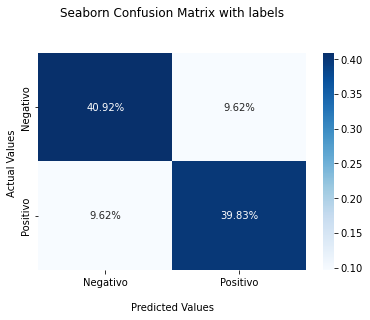

In [113]:
accuracy_train_rf = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_rf = metrics.accuracy_score(Y_test, test_prediction)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [114]:
kCrossValidation(rf, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.8049999999999999
Standard Deviation of scores:  0.010619688214715994



K cross validation, k=  11
Average scores:  0.8075007510841986
Standard Deviation of scores:  0.005098573999006043



K cross validation, k=  12
Average scores:  0.8064999999999999
Standard Deviation of scores:  0.008519585279421347



K cross validation, k=  13
Average scores:  0.8061662966863399
Standard Deviation of scores:  0.01714740123033934



K cross validation, k=  14
Average scores:  0.803499884013303
Standard Deviation of scores:  0.011295119964051603



K cross validation, k=  15
Average scores:  0.8108333333333333
Standard Deviation of scores:  0.008775755744600516





# 4. Multinomial Naive Bayes

## Task di classificazione

In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)
nb = MultinomialNB()
nb.fit(X_train, Y_train)

train_prediction = nb.predict(X_train)
test_prediction = nb.predict(X_test)

Accuracy score:  0.82
              precision    recall  f1-score   support

    Negativo       0.82      0.82      0.82      1213
    Positivo       0.82      0.82      0.82      1187

    accuracy                           0.82      2400
   macro avg       0.82      0.82      0.82      2400
weighted avg       0.82      0.82      0.82      2400



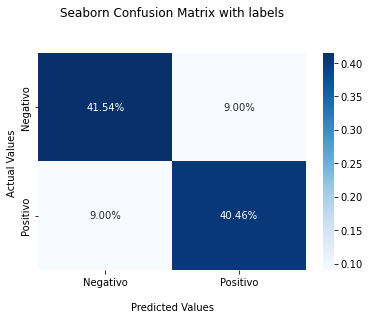

In [116]:
accuracy_train_nb = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_nb = metrics.accuracy_score(Y_test, test_prediction)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [117]:
kCrossValidation(nb, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.8231666666666667
Standard Deviation of scores:  0.00856186635936087



K cross validation, k=  11
Average scores:  0.8231677941211321
Standard Deviation of scores:  0.008382776987033819



K cross validation, k=  12
Average scores:  0.8236666666666665
Standard Deviation of scores:  0.007453559924999268



K cross validation, k=  13
Average scores:  0.8230005819388269
Standard Deviation of scores:  0.010592664511966129



K cross validation, k=  14
Average scores:  0.8225840670414766
Standard Deviation of scores:  0.0123571097447494



K cross validation, k=  15
Average scores:  0.8241666666666666
Standard Deviation of scores:  0.00976459022295469





# 5. KNN

## 5.1 Trovare il k migliore

### Prima di effettuare la classifcazione con il KNN, si cerca il valore k migliore che identifica il numero di neighbors su cui basarsi per la classficazione

### La ricerca di k viene effettuata per i seguenti valori: [9,11,13,15,17,19,97]

### Funzione che ricerca il k migliore

In [118]:
def findBestK(dataset, labels):
    X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=random_seed)
    error = []
    
    acc_train = []
    acc_test = []
    max_acc_test = 0
    max_acc_train = 0
    best_k = 0
    
    root = int(math.sqrt(X_train.shape[0]))
    k = [9,11,13,15,17,19]
    k.append(root)
    
    for i in k:
        print(str(i) + " Neighbors")
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred_i = knn.predict(X_test)
        
        error.append(np.mean(pred_i != Y_test))
        
        print("train: ", knn.score(X_train, Y_train))
        print("test: ", knn.score(X_test, Y_test))
        acc_train.append(knn.score(X_train, Y_train))
        acc_test.append(knn.score(X_test, Y_test))
        print()
        if knn.score(X_train, Y_train) >= max_acc_train and knn.score(X_test, Y_test) >= max_acc_test:
            best_k = i
            max_acc_test = knn.score(X_test, Y_test)
            max_acc_train = knn.score(X_train, Y_train)
        
    print("\nErrori per i vari k:\n")
    print(error)
    
    x=[9,11,13,15,17,19,97]
    values = range(len(x))

    plt.figure(figsize=(12, 6))
    plt.xticks(values,x)
    plt.plot(values, error, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')

    return best_k

## 5.2 KNN: Classificazione

### Task di classificazione

In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)


9 Neighbors
train:  0.6104166666666667
test:  0.54

11 Neighbors
train:  0.5790625
test:  0.5320833333333334

13 Neighbors
train:  0.5598958333333334
test:  0.5258333333333334

15 Neighbors
train:  0.5489583333333333
test:  0.5241666666666667

17 Neighbors
train:  0.5434375
test:  0.5229166666666667

19 Neighbors
train:  0.5421875
test:  0.5258333333333334

97 Neighbors
train:  0.5359375
test:  0.5245833333333333


Errori per i vari k:

[0.46, 0.46791666666666665, 0.4741666666666667, 0.47583333333333333, 0.47708333333333336, 0.4741666666666667, 0.47541666666666665]


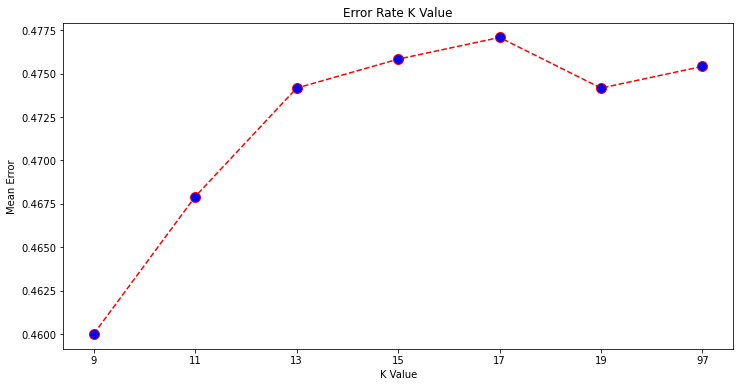

In [120]:
k = findBestK(featureSelection_df, labels)
knc = KNeighborsClassifier(n_neighbors=k, weights="distance")
knc.fit(X_train, Y_train)


train_prediction = knc.predict(X_train)
test_prediction = knc.predict(X_test)


Accuracy score:  0.5404166666666667
              precision    recall  f1-score   support

    Negativo       0.88      0.10      0.19      1213
    Positivo       0.52      0.99      0.68      1187

    accuracy                           0.54      2400
   macro avg       0.70      0.55      0.43      2400
weighted avg       0.70      0.54      0.43      2400



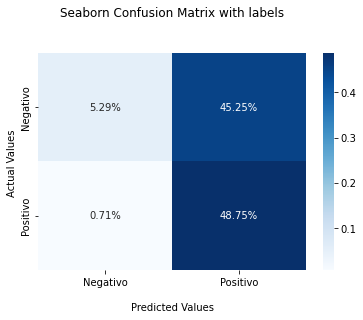

In [121]:
accuracy_train_knn = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_knn = metrics.accuracy_score(Y_test, test_prediction)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [122]:
kCrossValidation(knc, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.5578333333333333
Standard Deviation of scores:  0.006626965117357015



K cross validation, k=  11
Average scores:  0.5579165038999044
Standard Deviation of scores:  0.008445549926805445



K cross validation, k=  12
Average scores:  0.5598333333333333
Standard Deviation of scores:  0.018774243585887057



K cross validation, k=  13
Average scores:  0.5579165327269335
Standard Deviation of scores:  0.013404749852763968



K cross validation, k=  14
Average scores:  0.5570016331393228
Standard Deviation of scores:  0.01016748399428705



K cross validation, k=  15
Average scores:  0.5575
Standard Deviation of scores:  0.009800085033644693





# 6. Artificial Neural Network

## 6.1 Ottimizzazione dei parametri della rete neurale

In [123]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)

In [124]:
mlp = MLPClassifier(max_iter=200, random_state = random_seed)

### Paramatri su cui viene effettuata la ricerca

In [125]:
parameter_space = {
    'hidden_layer_sizes': [(200,150,100)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.005, 0.0001],
    'learning_rate': ['constant'],
    }

### Ricerca dei parametri

In [126]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, Y_train)


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=3), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.005, 0.0001],
                         'hidden_layer_sizes': [(200, 150, 100)],
                         'learning_rate': ['constant'],
                         'solver': ['adam', 'sgd']})

### Parametri migliori trovati

In [127]:
print('Parametri migliori:\n', clf.best_params_)

'''
'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'
'''

Parametri migliori:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}


In [128]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.788 (+/-0.023) for {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.734 (+/-0.238) for {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.792 (+/-0.021) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.734 (+/-0.238) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.761 (+/-0.011) for {'activation': 'logistic', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.501 (+/-0.003) for {'activation': 'logistic', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.763 (+/-0.023) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rat

## 6.2 Artificial Neural Network: Classificazione

### Prendo i parametri migliori trovati

In [129]:
best_params = clf.best_params_ 

hidden_layer_sizes_found = best_params.get('hidden_layer_sizes')
activation_found = best_params.get('activation')
solver_found = best_params.get('solver')
alpha_found = best_params.get('alpha')
learning_rate_found = best_params.get('learning_rate')

### Task di classificazione

In [131]:
mlp = MLPClassifier(max_iter=200, 
                    random_state = random_seed,
                    hidden_layer_sizes = hidden_layer_sizes_found,
                    activation = activation_found,
                    solver = solver_found,
                    alpha = alpha_found,
                    learning_rate = learning_rate_found
                   )

mlp.fit(X_train, Y_train)

train_prediction = mlp.predict(X_train)
test_prediction = mlp.predict(X_test)

Accuracy score:  0.79625
              precision    recall  f1-score   support

    Negativo       0.80      0.79      0.80      1213
    Positivo       0.79      0.80      0.80      1187

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



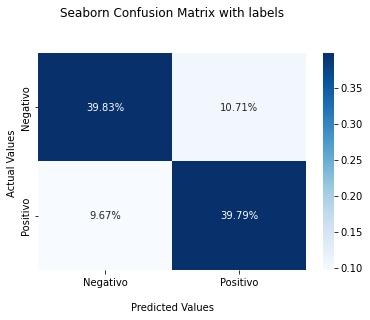

In [132]:
accuracy_train_nn = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_nn = metrics.accuracy_score(Y_test, test_prediction)

report_scores(Y_test, test_prediction)

# 7. Support Vector Machine

In [133]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)

## Valori su cui ho ottimizzato il classificatore SVC

In [134]:
# valori su cui ho ottimizzato il classificatore SVC

# kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
# C_values = [0.5,1,10,100]
# gamma_values = ['scale', 1, 0.1, 0.01, 0.001, 0.0001]

# parametri migliori
kernel_found = 'linear'
C_found = 0.5
gamma_found = 0.0001

### Task di classificazione

In [135]:
svm = SVC(random_state=random_seed, kernel = kernel_found, C = C_found, gamma = gamma_found)
svm.fit(X_train, Y_train)

train_prediction = svm.predict(X_train)
test_prediction = svm.predict(X_test)

Accuracy score:  0.8308333333333333
              precision    recall  f1-score   support

    Negativo       0.85      0.81      0.83      1213
    Positivo       0.82      0.85      0.83      1187

    accuracy                           0.83      2400
   macro avg       0.83      0.83      0.83      2400
weighted avg       0.83      0.83      0.83      2400



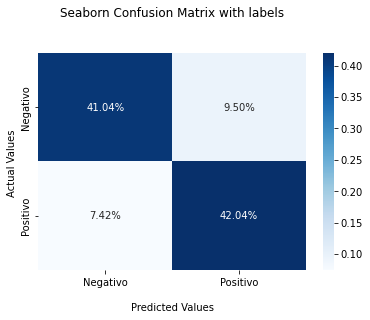

In [136]:
accuracy_train_svm = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_svm = metrics.accuracy_score(Y_test, test_prediction)

report_scores(Y_test, test_prediction)

# 8. Confronto modelli

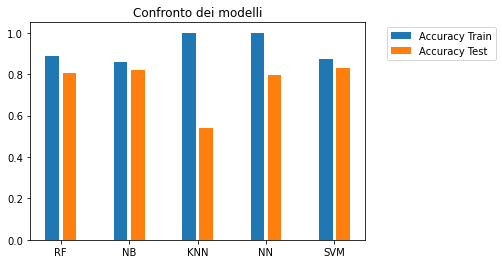

In [149]:
x_train = [1,5,9,13,17]
x_test = [2,6,10,14,18]

accuracy_train = [accuracy_train_rf, accuracy_train_nb, accuracy_train_knn, accuracy_train_nn, accuracy_train_svm]
accuracy_test = [accuracy_test_rf, accuracy_test_nb, accuracy_test_knn, accuracy_test_nn, accuracy_test_svm]

x_labels = [1.5,5.5,9.5,13.5,17.5]
name_labels = ["RF", "NB", "KNN", "NN", "SVM"]
plt.bar(x_train, accuracy_train, label='Accuracy Train')
plt.bar(x_test, accuracy_test, label='Accuracy Test')
plt.title("Confronto dei modelli")
plt.xticks(x_labels, name_labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()